# FlowGrad Toy Example

## Step 1:
Generate two distributions $\pi_0$ and $\pi_1$, and train a Rectified Flow

Shape of the samples from the target distribution: torch.Size([10000, 2])


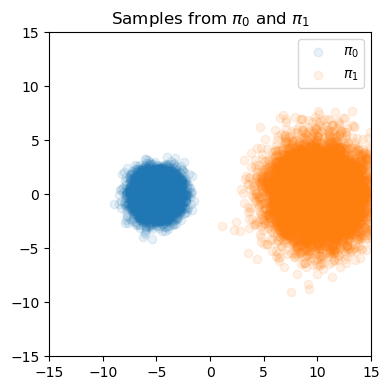

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.distributions import Normal, Categorical
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
import matplotlib.pyplot as plt
import torch.nn.functional as F

D = 10.
M = D+5
VAR = 5.0
DOT_SIZE = 4

initial_mix = Categorical(torch.tensor([1 for _ in range(1)]))
initial_comp = MultivariateNormal(torch.tensor([[-5.0, 0.0]]).float(), torch.stack([torch.eye(2) for _ in range(1)]))
initial_model = MixtureSameFamily(initial_mix, initial_comp)
initial_samples = initial_model.sample([10000])

target_mix = Categorical(torch.tensor([1 for _ in range(1)]))
target_comp = MultivariateNormal(torch.tensor([[10.0, 0.0]]).float(), VAR*torch.stack([torch.eye(2) for _ in range(1)]))
target_model = MixtureSameFamily(target_mix, target_comp)
target_samples = target_model.sample([10000])

print('Shape of the samples from the target distribution:', target_samples.shape)

plt.figure(figsize=(4,4))
plt.xlim(-M,M)
plt.ylim(-M,M)
plt.title(r'Samples from $\pi_0$ and $\pi_1$')
plt.scatter(initial_samples[:, 0].cpu().numpy(), initial_samples[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_0$')
plt.scatter(target_samples[:, 0].cpu().numpy(), target_samples[:, 1].cpu().numpy(), alpha=0.1, label=r'$\pi_1$')
plt.legend()

plt.tight_layout()

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_num=100):
        """
        A simple MLP for the task of learning the optimal transport map.
        input_dim: int, the dimension of the input data
        hidden_num: int, the number of hidden units
        """
        super().__init__()
        self.fc1 = nn.Linear(input_dim+1, hidden_num, bias=True)   # add time dimension
        self.fc2 = nn.Linear(hidden_num, hidden_num, bias=True)
        self.fc3 = nn.Linear(hidden_num, input_dim, bias=True)
        self.act = lambda x: torch.tanh(x)

    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=1)
        x = self.fc1(inputs)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)

        return x

In [3]:
class RectifiedFlow():
  def __init__(self, model=None, num_steps=1000):
    self.model = model
    self.N = num_steps

  def get_train_tuple(self, z0=None, z1=None):
    t = torch.rand((z1.shape[0], 1))
    z_t =  t * z1 + (1.-t) * z0
    target = z1 - z0

    return z_t, t, target

  @torch.no_grad()
  def sample_ode(self, z0=None, N=None):
    assert z0 is not None, "z0 must be provided!"

    # Initial sample
    batchsize = z0.shape[0]
    dt = 1. / (2 * N)
    t = torch.zeros((batchsize, 1))
    z_prev = z0.detach().clone()
    z = z_prev + self.model(z_prev, t) * dt
    traj = []
    traj.append(z_prev.detach().clone().cpu())
    traj.append(z.detach().clone().cpu())

    for i in range(1, 2 * N):
        num_t = i / (2. * N)
        t.fill_(num_t)
        print(f"Leapfrog, step = {i}, time = {num_t:.5f}, z_{i+1}=z_{i-1}+f(z_{i})*{2*dt:.3f}")
        pred = self.model(z, t)
        z_next = z_prev + pred * 2. * dt
        traj.append(z_next.detach().clone())
        z_prev, z = z, z_next
    
    return traj

In [4]:
def train_rectified_flow(rectified_flow, optimizer, pairs, batchsize, inner_iters):
  loss_curve = []
  for i in range(inner_iters+1):
    optimizer.zero_grad()
    indices = torch.randperm(len(pairs))[:batchsize]
    batch = pairs[indices]
    z0 = batch[:, 0].detach().clone()
    z1 = batch[:, 1].detach().clone()
    z_t, t, target = rectified_flow.get_train_tuple(z0=z0, z1=z1)

    pred = rectified_flow.model(z_t, t)
    loss = (target - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
    loss = loss.mean()
    loss.backward()

    optimizer.step()
    loss_curve.append(np.log(loss.item())) ## to store the loss curve

  return rectified_flow, loss_curve

In [5]:
@torch.no_grad()
def draw_plot(rectified_flow, z0, z1, N=None):
  traj = rectified_flow.sample_ode(z0=z0, N=N)

  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)

  plt.scatter(z1[:, 0].cpu().numpy(), z1[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
  plt.scatter(traj[0][:, 0].cpu().numpy(), traj[0][:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
  plt.scatter(traj[-1][:, 0].cpu().numpy(), traj[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)
  plt.legend()
  plt.title('Distribution')
  plt.tight_layout()

  traj_particles = torch.stack(traj)
  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)
  plt.axis('equal')
  for i in range(100):
    plt.plot(traj_particles[:, i, 0], traj_particles[:, i, 1])
  plt.title('Transport Trajectory')
  plt.tight_layout()

In [6]:
x0 = initial_model.sample([50000])
x1 = target_samples.repeat(5, 1)
x_pairs = torch.stack([x0, x1], dim=1)
print(x_pairs.shape)

torch.Size([50000, 2, 2])


Text(0.5, 1.0, 'Training Loss Curve')

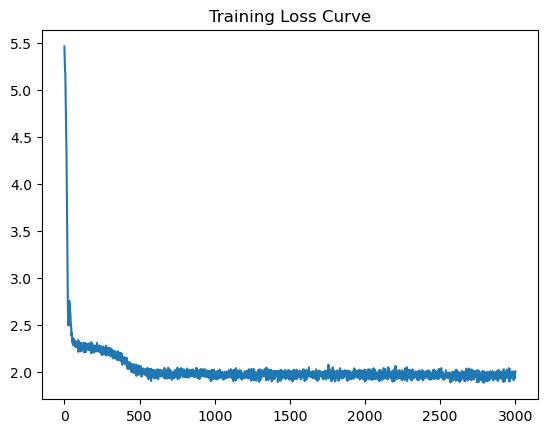

In [7]:
iterations = 3000
batchsize = 2048
input_dim = 2

rectified_flow_1 = RectifiedFlow(model=MLP(input_dim, hidden_num=100), num_steps=1000)
optimizer = torch.optim.Adam(rectified_flow_1.model.parameters(), lr=5e-3)

rectified_flow_1, loss_curve = train_rectified_flow(rectified_flow_1, optimizer, x_pairs, batchsize, iterations)
plt.plot(np.linspace(0, iterations, iterations+1), loss_curve[:(iterations+1)])
plt.title('Training Loss Curve')

Leapfrog, step = 1, time = 0.00050, z_2=z_0+f(z_1)*0.001
Leapfrog, step = 2, time = 0.00100, z_3=z_1+f(z_2)*0.001
Leapfrog, step = 3, time = 0.00150, z_4=z_2+f(z_3)*0.001
Leapfrog, step = 4, time = 0.00200, z_5=z_3+f(z_4)*0.001
Leapfrog, step = 5, time = 0.00250, z_6=z_4+f(z_5)*0.001
Leapfrog, step = 6, time = 0.00300, z_7=z_5+f(z_6)*0.001
Leapfrog, step = 7, time = 0.00350, z_8=z_6+f(z_7)*0.001
Leapfrog, step = 8, time = 0.00400, z_9=z_7+f(z_8)*0.001
Leapfrog, step = 9, time = 0.00450, z_10=z_8+f(z_9)*0.001
Leapfrog, step = 10, time = 0.00500, z_11=z_9+f(z_10)*0.001
Leapfrog, step = 11, time = 0.00550, z_12=z_10+f(z_11)*0.001
Leapfrog, step = 12, time = 0.00600, z_13=z_11+f(z_12)*0.001
Leapfrog, step = 13, time = 0.00650, z_14=z_12+f(z_13)*0.001
Leapfrog, step = 14, time = 0.00700, z_15=z_13+f(z_14)*0.001
Leapfrog, step = 15, time = 0.00750, z_16=z_14+f(z_15)*0.001
Leapfrog, step = 16, time = 0.00800, z_17=z_15+f(z_16)*0.001
Leapfrog, step = 17, time = 0.00850, z_18=z_16+f(z_17)*0.001

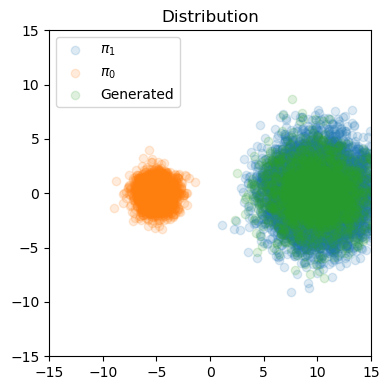

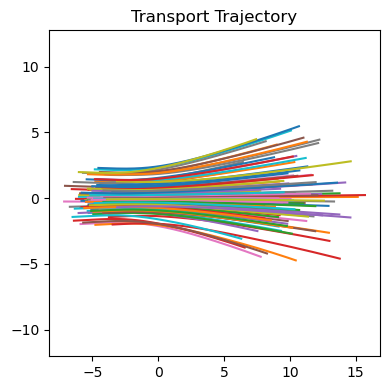

In [8]:
draw_plot(rectified_flow_1, z0=initial_model.sample([2000]), z1=target_samples.detach().clone(), N=1000)

## Step 2: Control the output with FlowGrad

Now we have the PF ODE model and we can control it with FlowGrad.
We use a very simple loss.
Denote the end point of the PF ODE as $z_1 = (x,y)$, we define the loss function as $L(z_1) = (x-10)^2 + (y-5)^2$.
We want to optimize the trajectory to minimize $L(z_1)$, where $p$ is the end point of the trajectory.

In [9]:
def flowgrad_optimization(z0, u_ind, dynamic, N=100, L_N=None, u_init=None,  number_of_iterations=1000, penalty_coeff=0.0,
                                  straightness_threshold=5e-3, lr=1.0):
    """
    u_ind: u_index, here a list [1, 2, 3, ..., 99, 100]
    dynamic: the velocity field, here is model_fn
    u_init: initial control field u, default all 0s
    L_N: Loss function for flow control at time step N, here L_N = lambda x: (x[:, 0] - 10.).pow(2).sum() + (x[:, 1] - 5.).pow(2).sum()
    """
    device = z0.device
    shape = z0.shape
    print("z0 shape: [batch_size, dim] = ", shape)
    u = {}
    if u_init is None:
        for ind in u_ind:
            u[ind] = torch.zeros_like(z0).to(z0.device)
            u[ind].requires_grad = True
            u[ind].grad = torch.zeros_like(u[ind], device=u[ind].device)
    else:
        for ind in u_init.keys():
            u[ind] = u_init[ind].detach().clone().to(z0.device)

        for ind in u_ind:
            try:
                u[ind].requires_grad = True
            except:
                u[ind] = torch.zeros_like(z0).to(z0.device)
                u[ind].requires_grad = True
            u[ind].grad = torch.zeros_like(u[ind], device=u[ind].device)

    ### L is supposed to be a function (ideally, a lambda expression). The output of L should be a scalar.
    for i in range(number_of_iterations):
        print('-' * 20, '\n')
        print('-' * 15, 'Iteration:', i, '-' * 15)
        
        for ind in u.keys():
            u[ind] = u[ind].detach().clone().requires_grad_(True)
        
        u_optimizer = torch.optim.SGD([u[key] for key in u_ind], lr=lr) ### white black 5e-3
        u_optimizer.zero_grad()

        ### get the forward simulation result and the non-uniform discretization trajectory
        ### non_uniform_set: indices and interval length (t_{j+1} - t_j)
        z_traj = generate_traj_with_grad(dynamic, z0, u=u, N=N)
        
        dt = 1. / (2. * N)

        ### use lambda to store \nabla L
        # inputs = torch.zeros(z_traj[-1].shape, device=device)
        # inputs.data = z_traj[-1].to(device).detach().clone()
        # inputs.requires_grad = True
        # loss = L_N(inputs)
        loss = L_N(z_traj[-1])

        u_grad_direct = {}
        loss_grad_z_direct = {}
        for j in range(2 * N - 1, -1, -1):
            assert j in u_ind
            u_grad_direct[j] = torch.autograd.grad(loss, u[j], retain_graph=True, create_graph=True)[0]
            loss_grad_z_direct[j] = torch.autograd.grad(loss, z_traj[j], retain_graph=True, create_graph=True)[0]
            # print(f"u[{j}]: {u[j]}, grad_u: {u_grad_direct[j]}, grad_z: {loss_grad_z_direct[j]}")

        # loss_grad_z_2N
        loss_grad_z_prev = torch.autograd.grad(loss, z_traj[-1], retain_graph=False)[0]  
        t = torch.ones((1, 1)) * (2. * N - 1) / (2. * N)
        func = lambda x : (2 * dt * dynamic(x.contiguous().reshape(shape), t)).view(-1) 
        # loss_grad_z_2N-1
        loss_grad_z = (torch.autograd.functional.vjp(func, z_traj[2 * N - 1].to(device).detach().clone().view(-1) + u[2 * N - 1].to(device).detach().clone().view(-1), 
                                                     v=loss_grad_z_prev.detach().clone().reshape(-1))[1]).reshape(shape)
        # print("Check !!!", loss_grad_z == loss_grad_z_direct[2 * N - 1])
        # print(loss_grad_z)
        # print(loss_grad_z_direct[2 * N - 1])

        print('   End point :', z_traj[-1].view(-1).detach().cpu().numpy())
        print('   L:%.6f'%loss.detach().cpu().numpy())
        print('   Nabla L:', loss_grad_z_prev.reshape(-1).detach().cpu().numpy())

        for j in range(2 * N - 1, -1, -1):
            assert j in u_ind
            
            u[j].grad = loss_grad_z.detach().clone()
            # u[j].grad = u_grad_direct[j]
            # print(f"Step {j} calculated gradient: ", u[j].grad)
            # print("autograd: ", u_grad_direct[j])
            # print("check calculation: ", u[j].grad == u_grad_direct[j])
            
            
            if j == 0: break

            func1 = lambda x : x.contiguous().reshape(shape).view(-1)
            t_next = torch.ones((1, 1)) * (j - 1.) / (2. * N) # input = z_next
            
            func2 = lambda x : (2 * dt * dynamic(x.contiguous().reshape(shape) + u[j - 1].detach().clone(), t_next)).view(-1)   # input = z_next

            if j == 1 :             
                func2 = lambda x : (dt * dynamic(x.contiguous().reshape(shape) + u[j - 1].detach().clone(), t_next)).view(-1)   # input = z_next


            vjp = torch.autograd.functional.vjp(func1, z_traj[j - 1].to(device).detach().clone().view(-1), loss_grad_z_prev.detach().clone().reshape(-1))[1] + \
                                    torch.autograd.functional.vjp(func2, z_traj[j - 1].to(device).detach().clone().view(-1), loss_grad_z.detach().clone().reshape(-1))[1]

            loss_grad_z_next = vjp.detach().clone().contiguous().reshape(shape)

            loss_grad_z, loss_grad_z_prev = loss_grad_z_next, loss_grad_z


        u_optimizer.step()

    opt_u = {}
    for ind in u.keys():
        opt_u[ind] = u[ind].detach().clone()

    return opt_u

@torch.no_grad()
def generate_traj(dynamic, z0, u=None, N=100, straightness_threshold=None):  # NOTE: 废了的方案
    assert z0 is not None, "z0 must be provided!"

    dt = 1. / (2 * N)
    t = torch.zeros((z0.shape[0], 1), device=z0.device)
    z_prev = z0.detach().clone()
    z = z_prev + dynamic(z_prev, t) * dt
    traj = []
    traj.append(z_prev.detach().clone().cpu())
    traj.append(z.detach().clone().cpu())
    pred_list = []
    
    for i in range(1, 2 * N):
        num_t = i / (2. * N)
        t.fill_(num_t)
        # print(f"Leapfrog, step = {i}, time = {num_t:.5f}, z_{i+1}=z_{i-1}+f(z_{i})*{2*dt:.3f}")
        # print(f"pos z_prev: {z_prev}, z: {z}")
        pred = dynamic(z, t)
        # print("predicted direction: ", pred * 2. * dt)
        if (u is not None):
            try:
                pred = pred + u[i]
                # print("control: ", u[i] * 2. * dt)
            except:
                pass
        z_next = z_prev + pred * 2. * dt
        # print(f"pos to: {z_next}")
        # print("")
        traj.append(z_next.detach().clone().cpu())
        z_prev, z = z, z_next
        pred_list.append(pred.detach().clone().cpu())
    
    return traj


def generate_traj_with_grad(dynamic, z0=None, u=None, N=None):
    assert z0 is not None, "z0 must be provided!"
    
    dt = 1. / (2 * N)
    t = torch.zeros((z0.shape[0], 1), device=z0.device)
    z_prev = z0.detach().clone()
    z_prev.requires_grad = True
    traj = []
    traj.append(z_prev)
    
    if u is not None:
        z = z_prev + dynamic(z_prev + u[0], t) * dt
    else:
        z = z_prev + dynamic(z_prev, t) * dt
    traj.append(z)
    pred_list = []
    
    for i in range(1, 2 * N):
        num_t = i / (2. * N)
        t.fill_(num_t)
        
        if u is not None:
            pred = dynamic(z + u[i], t)
            z_next = z_prev + u[i - 1] + pred * 2. * dt
        else:
            pred = dynamic(z, t)
            z_next = z_prev + pred * 2. * dt
        traj.append(z_next)
        z_prev, z = z, z_next
        pred_list.append(pred.detach())
    
    return traj

We randomly initilize a $z_0$, and optimize the end point $z_1$ with FlowGrad; The loss gradually decreases

(If the end point is not optimized to $(10,5)$, try optimize it for longer time or change intial $z_0$).

In [10]:
# z0 = initial_model.sample([1])
z0 = torch.tensor((-3, -2.)).unsqueeze(0)
print('z0 at initialization:', z0)
L = lambda x: (x[:, 0] - 10.).pow(2).sum() + (x[:, 1] - 5.).pow(2).sum()
model_fn = rectified_flow_1.model

traj = generate_traj_with_grad(model_fn, z0=initial_model.sample([2000]), N=100)

num_steps = 50
traj_org = generate_traj_with_grad(model_fn, z0=z0, N=num_steps)

opt_u = flowgrad_optimization(z0.detach().clone(), u_ind=[i for i in range(2 * num_steps)], \
                                      dynamic=model_fn, N=num_steps, L_N=L, number_of_iterations=30, penalty_coeff=1e-3, lr=0.001)

traj_opt = generate_traj_with_grad(model_fn, z0=z0, u=opt_u, N=num_steps)
print('z0 after FlowGrad optimization:', traj_opt[-1])

z_traj_cllt = []
z_traj_cllt.append(traj_org)
z_traj_cllt.append(traj_opt)

z0 at initialization: tensor([[-3., -2.]])
z0 shape: [batch_size, dim] =  torch.Size([1, 2])
-------------------- 

--------------- Iteration: 0 ---------------
   End point : [15.067649  -4.4209995]
   L:114.436295
   Nabla L: [ 10.135298 -18.842   ]
-------------------- 

--------------- Iteration: 1 ---------------
   End point : [14.25607  -2.793305]
   L:78.849739
   Nabla L: [  8.51214 -15.58661]
-------------------- 

--------------- Iteration: 2 ---------------
   End point : [13.327984  -1.3381608]
   L:51.247757
   Nabla L: [  6.6559677 -12.676321 ]
-------------------- 

--------------- Iteration: 3 ---------------
   End point : [12.629156   -0.06319428]
   L:32.548397
   Nabla L: [  5.258312 -10.126389]
-------------------- 

--------------- Iteration: 4 ---------------
   End point : [12.094368    0.96888953]
   L:20.636227
   Nabla L: [ 4.188736 -8.062221]
-------------------- 

--------------- Iteration: 5 ---------------
   End point : [11.672063   1.7618287]
   L:13.2

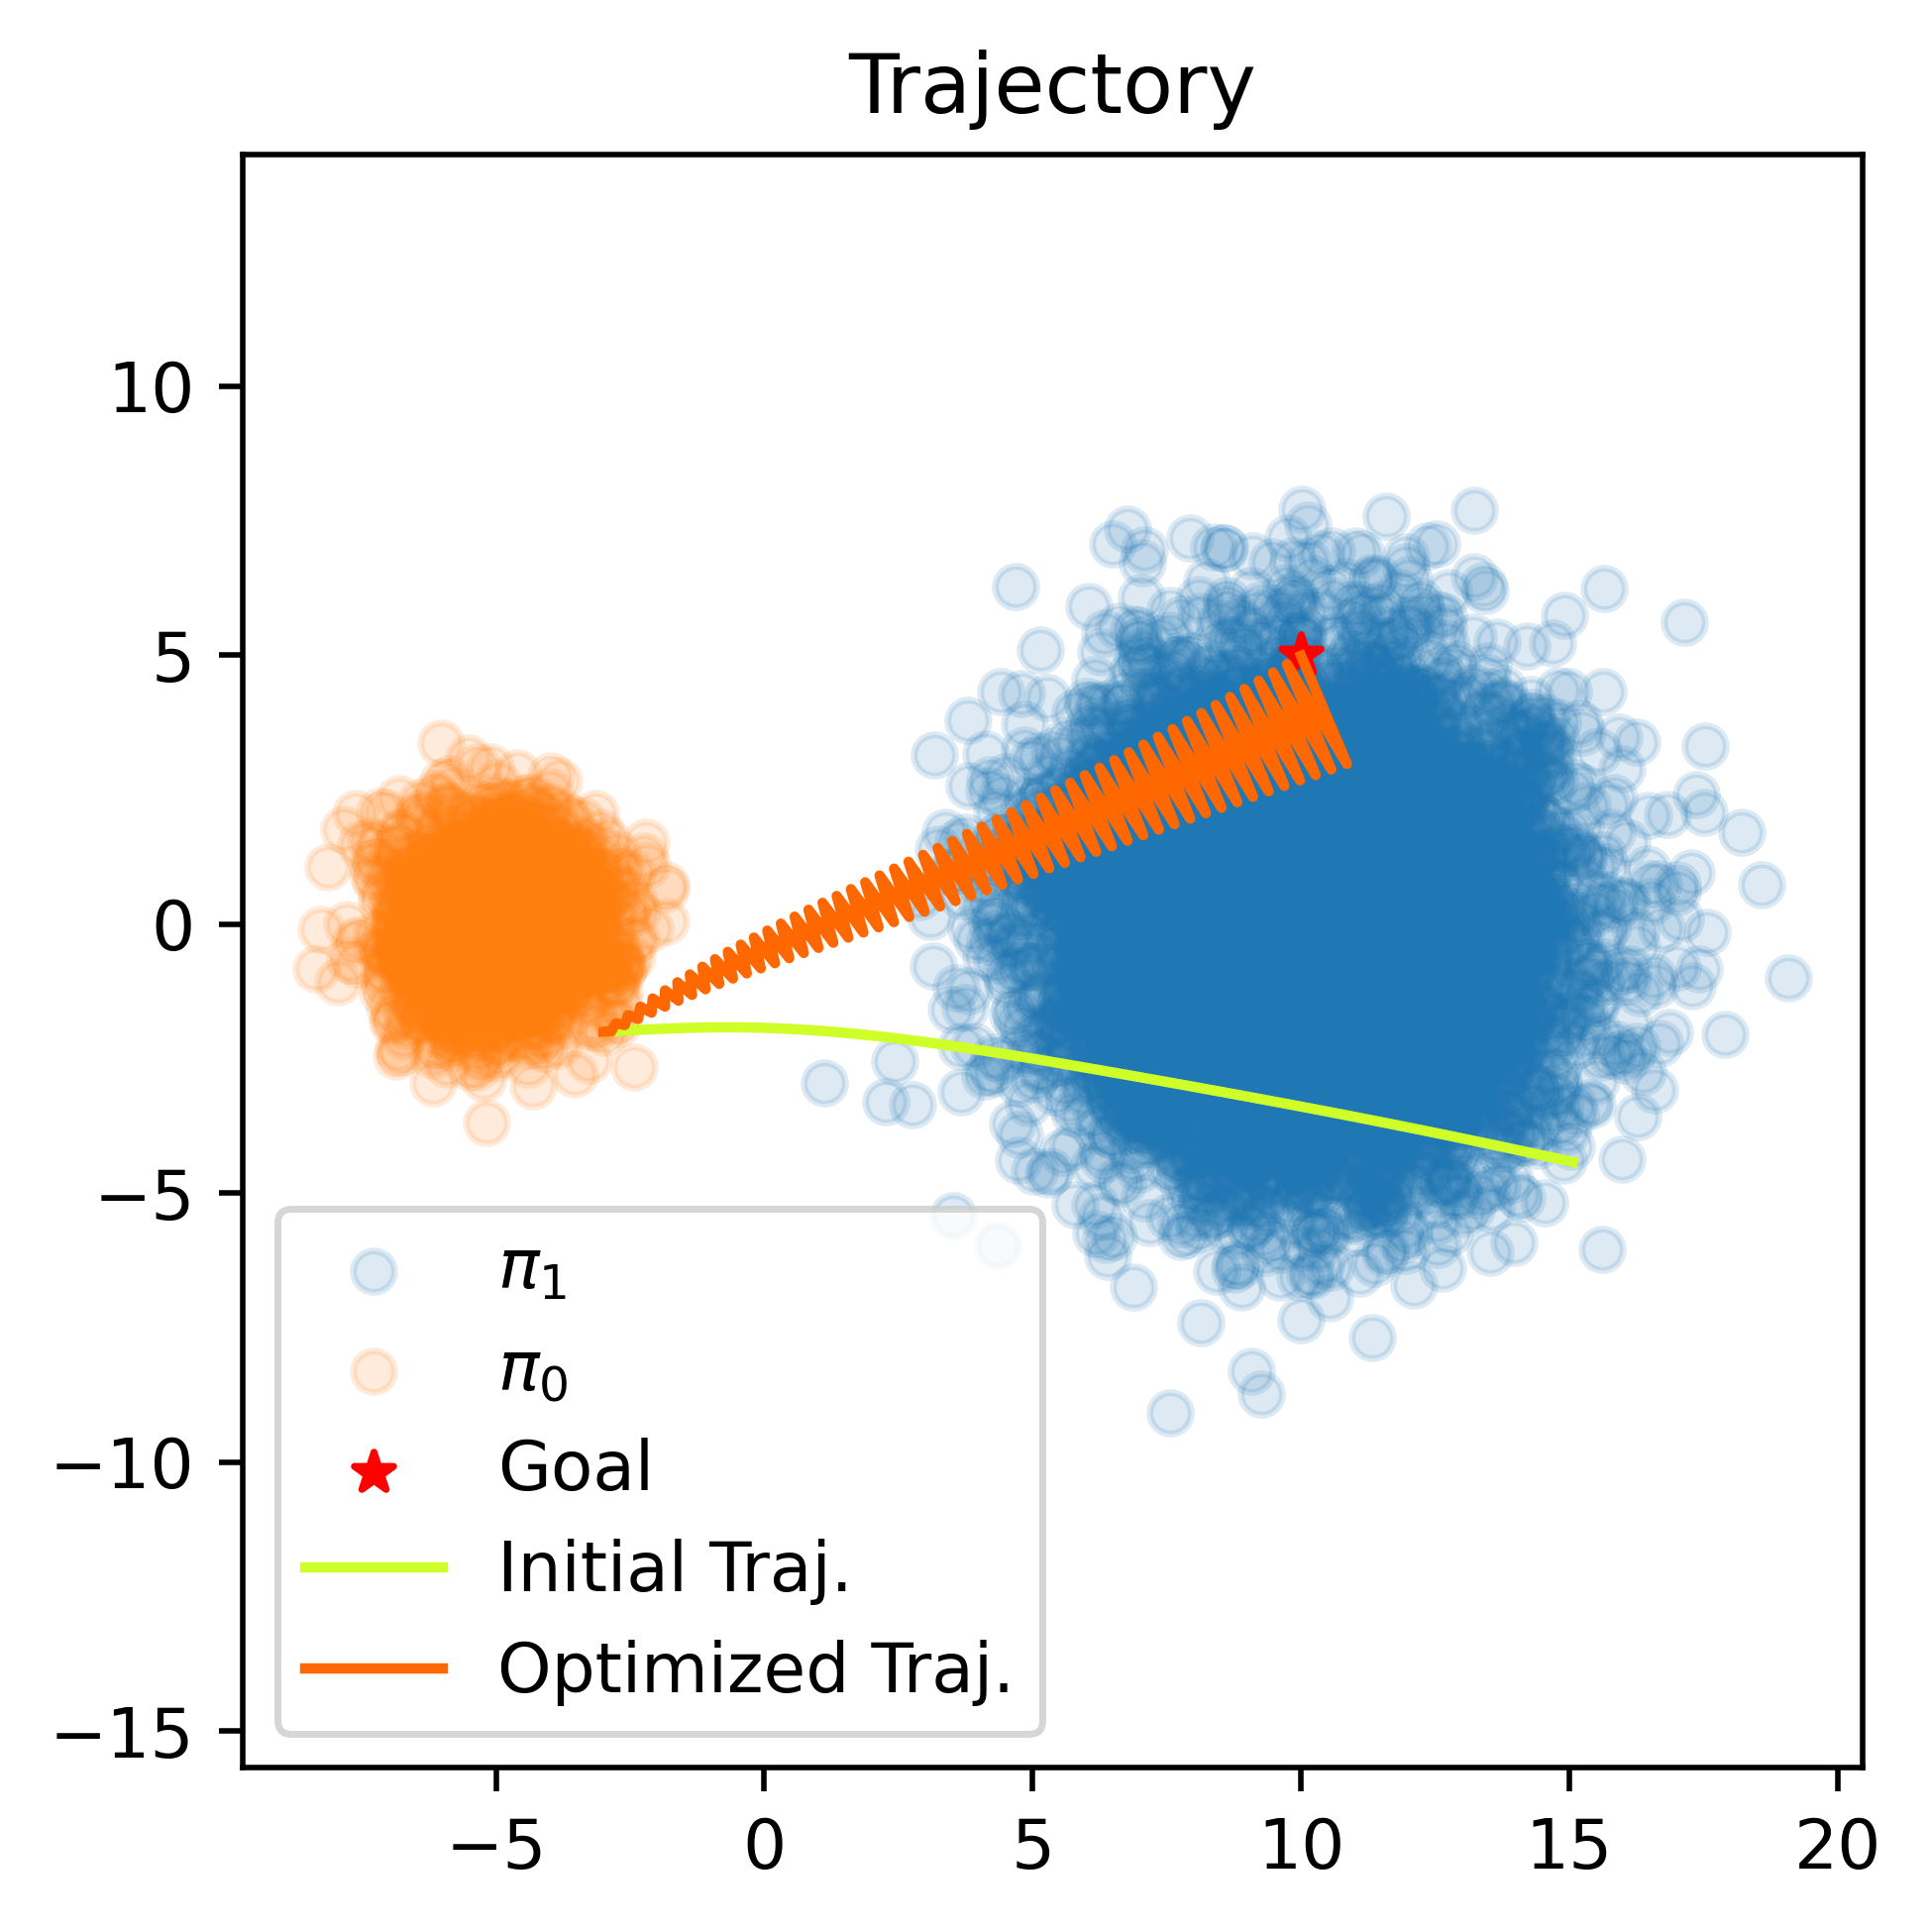

In [11]:
plt.figure(figsize=(4, 4), dpi=500)
plt.xlim(-M,M)
plt.ylim(-M,M)
plt.axis('equal')

plt.scatter(target_samples[:, 0].cpu().numpy(), target_samples[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
plt.scatter(traj[0][:, 0].detach().cpu().numpy(), traj[0][:, 1].detach().cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
plt.scatter([10.], [5.], label='Goal', alpha=1.0, marker='*', c='r')

from matplotlib import cm
number_of_lines= len(z_traj_cllt)
cm_subsection = np.linspace(0.6, 0.8, number_of_lines)
colors = [ cm.jet(x) for x in cm_subsection ]
traj_particles = torch.stack(z_traj_cllt[0]).detach().cpu().numpy()
plt.plot(traj_particles[:, 0, 0], traj_particles[:, 0, 1], color=colors[0], label='Initial Traj.')
traj_particles = torch.stack(z_traj_cllt[1]).detach().cpu().numpy()
plt.plot(traj_particles[:, 0, 0], traj_particles[:, 0, 1], color=colors[1], label='Optimized Traj.')

plt.legend()
plt.title('Trajectory')
plt.tight_layout()